# Simple PINN for an elastic plate with an elliptical hole 

## Geometry

We want to model a quarter of a plate with an elliptical hole. The domain itself is represented by collocation points, the boundaries are represented by uniformly sampled points along the perimeter.

In [71]:
import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
import numpy as np
from scipy.stats import qmc
from plotly.express.colors import sequential
import plotly.graph_objects as go
import plotly.figure_factory as ff
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns


torch.set_default_dtype(torch.float64)
from global_constants import L, R, MU, LBD, N1, N2

from new_plate_elliptic_hole import Plate 

# Elliptical axis in x direction
Rx = 0.14
Ry = R**2 / Rx
# Edge samples
N = 40
# Number of collocation points
M = 500

# Epochs
epochs = 5000
# Batch size
batch_size = 64
# Learning rate
lr = 0.0005 #0.001
# Scheduler step width
scheduler_step = 500
# Gamma factor of scheduler
scheduler_gamma = 0.6
# Number of hidden neurons
hn = 256 #recommended by wang et al



def generate_radii_list(min_Ra_x, max_Ra_x, step):
    if step == 0:
        rad_x_list = [min_Ra_x, max_Ra_x]
    else:
        num_steps = int((max_Ra_x - min_Ra_x) / step) + 1
        rad_x_list = np.linspace(min_Ra_x, max_Ra_x, num_steps)
        rad_x_list = [round(rad_x, 2) for rad_x in rad_x_list]
    rad_y_list = []
    for rad_x in rad_x_list:
        rad_y_list.append(R**2 / rad_x)
    return rad_x_list, rad_y_list

def generate_multiple_plates(min_Ra_x, max_Ra_x, step_size):

    list_collo = torch.empty(0,3,requires_grad=True)
    list_top = torch.empty(0,3,requires_grad=True)
    list_right = torch.empty(0,3,requires_grad=True)
    list_left = torch.empty(0,3,requires_grad=True)
    list_bottom = torch.empty(0,3,requires_grad=True)
    list_hole = torch.empty(0,5,requires_grad=True)

    rad_x_list, rad_y_list = generate_radii_list(min_Ra_x, max_Ra_x, step_size)
    for rad_x in rad_x_list:
        p1 = Plate(rad_x, N, M)
        #data_one_plate -> [collocation, top, right, left, bottom, hole, n_hole]
        collo_points, top_points, right_points, left_points, bottom_points, hole_points = p1.generate_dataset()
        list_collo = torch.cat((list_collo, collo_points), dim=0)
        list_top = torch.cat((list_top, top_points), dim=0)
        list_right = torch.cat((list_right, right_points), dim=0)
        list_left = torch.cat((list_left, left_points), dim=0)
        list_bottom = torch.cat((list_bottom, bottom_points), dim=0)
        list_hole = torch.cat((list_hole, hole_points), dim=0)
        
    return list_collo, list_top, list_right, list_left, list_bottom, list_hole 

def generate_multiple_plates_dict(min_Ra_x, max_Ra_x):
    dict_plate_points = dict()
    tuples = [
            ("x_collo", 0, 0),
            ("y_collo", 0, 1),
            ("x_top", 1, 0),
            ("y_top", 1, 1),
            ("x_right", 2, 0),
            ("y_right", 2, 1),
            ("x_left", 3, 0),
            ("y_left", 3, 1),
            ("x_bottom", 4, 0),
            ("y_bottom", 4, 1),
            ("x_hole", 5, 0),
            ("y_hole", 5, 1),   
        ] 
    
    rad_x_list, rad_y_list = generate_radii_list(min_Ra_x, max_Ra_x, 0.01)
    for rad_x in rad_x_list:
        p1 = Plate(rad_x, N, M)
        #data_one_plate -> [collocation, top, right, left, bottom, hole, n_hole]
        data_one_plate = p1.generate_dataset()

        for tuple in tuples:
            key = tuple[0]
            dict_plate_points.setdefault(key, []).append(data_one_plate[tuple[1]][:,tuple[2]])
        #plotting one plate
        #p1.plot_plate_with_hole(*data_one_plate)
    for key in dict_plate_points: 
        #appending list of tensors to one tensor
        dict_plate_points[key] = torch.cat(dict_plate_points[key])
        print(key, "besteht aus",dict_plate_points[key].size(), "Datenpunkten")

    collo_points = torch.column_stack([dict_plate_points["x_collo"], dict_plate_points["y_collo"]])
    top_points = torch.column_stack([dict_plate_points["x_top"], dict_plate_points["y_top"]])
    right_points = torch.column_stack([dict_plate_points["x_right"], dict_plate_points["y_right"]])
    left_points = torch.column_stack([dict_plate_points["x_left"], dict_plate_points["y_left"]])
    bottom_points = torch.column_stack([dict_plate_points["x_bottom"], dict_plate_points["y_bottom"]])
    hole_points = torch.column_stack([dict_plate_points["x_hole"], dict_plate_points["y_hole"]])

    return collo_points, top_points, right_points, left_points, bottom_points, hole_points



p99 = Plate(0.14, N, M)
collocation, top, right, left, bottom, hole = p99.generate_dataset()
p99.plot_plate_with_hole(collocation, top, right, left, bottom, hole)


## The ANN model that approximates the displacement field

An ANN might be considered as a generic function approximator. In this case, it should approximated the function $u: \mathcal{R}^2 \rightarrow \mathcal{R}^2$ with five hidden layers having 20 neurons each.

In [72]:
class Net(torch.nn.Module):

    def torch_factorized_xavier_normal(self, mean = 1.0, stddev = 0.1):
        def init(layer_weight):
            w = torch.nn.init.xavier_normal_(layer_weight, gain=torch.nn.init.calculate_gain('tanh'))

            # print(f"shape of w_old: {np.shape(w)}, shape of layer_weight: {np.shape(layer_weight)}")
            # sns.displot(w.detach().numpy())
            # plt.show()

            s = torch.normal(mean, stddev, np.shape(layer_weight))
            s = torch.exp(s)
            v = w / s
            w = s * v

            print(f"shape of w_new: {np.shape(w)}, shape of layer_weight: {np.shape(layer_weight)}")
            # sns.displot(w.detach().numpy())
            # plt.show()
            
            return s, v
        return init
    
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = torch.nn.Linear(3, hn)
        #torch.nn.init.xavier_normal_(self.hidden_layer1.weight, gain=torch.nn.init.calculate_gain('tanh'))
        #sns.displot(self.hidden_layer1.weight.detach().numpy())
        #torch.nn.init.zeros_(self.hidden_layer1.bias)
        self.hidden_layer2 = torch.nn.Linear(hn, hn)
        #torch.nn.init.xavier_normal_(self.hidden_layer2.weight, gain=torch.nn.init.calculate_gain('tanh'))
        #torch.nn.init.zeros_(self.hidden_layer2.bias)
        self.hidden_layer3 = torch.nn.Linear(hn, hn)
        #torch.nn.init.xavier_normal_(self.hidden_layer3.weight, gain=torch.nn.init.calculate_gain('tanh'))
        #torch.nn.init.zeros_(self.hidden_layer3.bias)
        self.hidden_layer4 = torch.nn.Linear(hn, hn)
        #torch.nn.init.xavier_normal_(self.hidden_layer4.weight, gain=torch.nn.init.calculate_gain('tanh'))
        #torch.nn.init.zeros_(self.hidden_layer4.bias)
        self.output_layer = torch.nn.Linear(hn, 2)

        # #for weight initialization with normal distribution
        # for m in self.modules():
        #     if isinstance(m, torch.nn.Linear):
        #         m.weight.detach().normal_(mean= 0.0, std = 0.1)
        #         sns.displot(m.weight.detach().numpy())
        #         if m.bias is not None:
        #             m.bias.detach().zero_()
                    
        # #for weight initialization with glorot scheme            
        # for m in self.modules():
        #     if isinstance(m, torch.nn.Linear):
        #         torch.nn.init.xavier_normal_(m.weight, gain=torch.nn.init.calculate_gain('tanh'))
        #         sns.displot(m.weight.detach().numpy())
        #         if m.bias is not None:
        #             m.bias.detach().zero_()

        #for weight initialization with RWF (random weight factorization)
        # with torch.no_grad():
        #     for m in self.modules():
        #         if isinstance(m, torch.nn.Linear):
        #             old_weight = m.weight.clone() 
        #             s, v = self.torch_factorized_xavier_normal()(m.weight)
        #             #m.weight.copy_((s*v))
        #             m.weight = torch.nn.Parameter(s * v)
        #             if m.bias is not None:
        #                 m.bias.detach().zero_()

        #             # Check if the weights have been changed
        #             if torch.equal(old_weight, m.weight):
        #                 print("The weights have not been changed")
        #             else:
        #                 print("The weights have been successfully changed.")
        #                 # sns.displot(m.weight.detach().numpy())
        #                 # plt.show()



    def forward(self, inputs):

        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)
        return output
    

#net is initilized in training 
# net = Net()


def reset_net_parameters(net):
    for layer in net.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

#reset all network parameters    
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()




## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the following PDE 
$$\frac{\partial \sigma_{11}}{\partial x_1} + \frac{\partial \sigma_{12}}{\partial x_2} - b_1 = 0$$
$$\frac{\partial \sigma_{21}}{\partial x_1} + \frac{\partial \sigma_{22}}{\partial x_2} - b_2 = 0$$
with stress 
$$ \sigma_{ij} = 2\mu \varepsilon_{ij} + \lambda \varepsilon_{kk} \delta_{ij} $$
and strain 
$$ \varepsilon_{ij} = \frac{1}{2} \left( \frac{\partial u_i}{\partial x_j} +  \frac{\partial u_j}{\partial x_i}\right).$$

In [73]:
def epsilon(xyr):
    # Compute deformation gradient
    #inputs = torch.column_stack([x,y])
    dudx = torch.func.jacrev(net)(xyr)
    # print(np.shape(xx))
    # print(xx)
    return 0.5 * (dudx[:,:-1] + dudx[:,:-1].T)

# def epsilon(x):
#     # Compute deformation gradient
#     disp = net(x)
#     print(np.shape(disp))
#     print(disp)
#     u = disp[:,0]
#     v = disp[:,1]
#     u_x = torch.autograd.grad(u.sum(), x[:, 0], create_graph=True)[0]
#     v_x = torch.autograd.grad(v.sum(), x[:, 0], create_graph=True)[0]
#     u_y = torch.autograd.grad(u.sum(), x[:, 1], create_graph=True)[0]
#     v_y = torch.autograd.grad(v.sum(), x[:, 1], create_graph=True)[0]

#     gradx = torch.column_stack([u_x, v_x])
#     grady = torch.column_stack([u_y, v_y])
#     gradient = torch.stack([gradx, grady], dim=2)

#    return 0.5 * (gradient + torch.transpose(gradient, 1, 2))

def sigma(xyr):
    # Compute (small deformation) strain
    eps = epsilon(xyr)
    # Compute linear elastic strain (assuming plane stress)
    return 2.0 * MU * eps + (2*LBD*MU)/(2*MU+LBD) * torch.trace(eps) * torch.eye(2)


def pde_residual(xyr):
    # Compute stress gradient
    dsdx = torch.func.jacrev(sigma)(xyr)
    # Momentum balance in x direction
    residual_x = dsdx[0, 0, 0] + dsdx[0, 1, 1] 
    # Momentum balance in y direction
    residual_y = dsdx[1, 0, 0] + dsdx[1, 1, 1]
    return residual_x, residual_y

## Boundary conditions

Left: 

$$ u_1 = 0$$

Bottom: 

$$ u_2 = 0$$

Top: 

$$ \sigma \cdot n = N_2 n$$

Right: 

$$ \sigma \cdot n = N_1 n$$

In [74]:
mse = torch.nn.MSELoss()


def compute_physics_losses(complete_collo, top, right, left, bottom, hole):
    # pde
    res_x, res_y = torch.vmap(pde_residual)(complete_collo)
    zeros = torch.zeros_like(res_x)
    pde_error = mse((res_x), zeros) + mse((res_y), zeros)

    # left boundary
    pred_left = net(left)
    bc_left = torch.zeros_like(pred_left[:, 0])
    left_error = mse(pred_left[:, 0], bc_left)

    # bottom boundary
    pred_bottom = net(bottom)
    bc_bottom = torch.zeros_like(pred_bottom[:, 1])
    bottom_error = mse(pred_bottom[:, 1], bc_bottom)

    # top boundary
    pred_stress_top = torch.vmap(sigma)(top)
    pred_s_top_yy = pred_stress_top[:,1,1]
    pred_s_top_xy = pred_stress_top[:,0,1]
    s_top_yy = N2*torch.ones_like(pred_s_top_yy)
    s_top_xy = torch.zeros_like(pred_s_top_xy)
    top_error = mse(pred_s_top_yy, s_top_yy) + mse(pred_s_top_xy, s_top_xy)

    # right boundary
    pred_stress_right = torch.vmap(sigma)(right)
    pred_s_right_xx = pred_stress_right[:,0,0]
    pred_s_right_xy = pred_stress_right[:,1,0]
    s_right_xx = N1*torch.ones_like(pred_s_right_xx)
    s_right_xy = torch.zeros_like(pred_s_right_xy)
    right_error = mse(pred_s_right_xx, s_right_xx) + mse(pred_s_right_xy, s_right_xy)


    # hole boundary
    stress_hole = torch.vmap(sigma)(hole[:,:3])
    n_hole = hole[:,-2:]
    traction = torch.einsum("...ij,...j->...i", stress_hole, n_hole)
    zeros = torch.zeros_like(traction[:, 0])
    hole_error = mse(traction[:, 0], zeros) + mse(traction[:, 1], zeros)


    return (left_error, right_error, bottom_error, top_error, hole_error, pde_error)

## Training 

Starting with Adam optimizer...


  2%|▏         | 99/5000 [02:15<1:50:14,  1.35s/it]C:\Users\sebie\AppData\Local\Temp\ipykernel_13180\3143593890.py:208: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  2%|▏         | 100/5000 [02:17<1:51:18,  1.36s/it]

for weight 0 new weight_value: 851.8702366466972
for weight 1 new weight_value: 6.555164706836901
for weight 2 new weight_value: 57.35044262579759
for weight 3 new weight_value: 1.001996263645222
total_loss: 9.114229529527995, hole_loss:  0.4240281967519306, neumann_loss:  4.246955593300111, pde_loss: 4.412242099094504, dirichlet_loss: 0.031003640381448525


  4%|▍         | 200/5000 [04:35<1:50:52,  1.39s/it]

for weight 0 new weight_value: 781.445196045085
for weight 1 new weight_value: 6.445013915060283
for weight 2 new weight_value: 19634.991119657836
for weight 3 new weight_value: 1.0252751460882796
total_loss: 23.680765615577265, hole_loss:  0.00023103971364090244, neumann_loss:  22.244585941782425, pde_loss: 0.17775053760147597, dirichlet_loss: 1.2581980964797237


  6%|▌         | 300/5000 [06:53<1:47:17,  1.37s/it]

for weight 0 new weight_value: 78804954.54847948
for weight 1 new weight_value: 5.904531613003278
for weight 2 new weight_value: 276579464.3878521
for weight 3 new weight_value: 3.5108735032235012
total_loss: 27.55962429904347, hole_loss:  0.0002909346885031585, neumann_loss:  25.78429708803742, pde_loss: 8.464488171943536e-05, dirichlet_loss: 1.774951631435826


  8%|▊         | 400/5000 [09:14<2:06:51,  1.65s/it]

for weight 0 new weight_value: 71017000.20295084
for weight 1 new weight_value: 137.30771413988077
for weight 2 new weight_value: 853101666.490448
for weight 3 new weight_value: 3.2598620798115516
total_loss: 27.594984166990823, hole_loss:  7.243827233628413e-07, neumann_loss:  27.5748192602159, pde_loss: 3.5895661966741392e-06, dirichlet_loss: 0.0201605928260033


 10%|█         | 500/5000 [11:35<1:44:38,  1.40s/it]

for weight 0 new weight_value: 219187789329833.66
for weight 1 new weight_value: 123.67694279520443
for weight 2 new weight_value: 99959433098136.8
for weight 3 new weight_value: 144278.74951195976
total_loss: 27.600335717823423, hole_loss:  4.693294665836806e-07, neumann_loss:  27.579904726392922, pde_loss: 3.0034936457872254e-07, dirichlet_loss: 0.020430221751671012


 12%|█▏        | 600/5000 [13:53<1:41:25,  1.38s/it]

for weight 0 new weight_value: 197351749886356.94
for weight 1 new weight_value: 5843.023477769259
for weight 2 new weight_value: 186857417879987.3
for weight 3 new weight_value: 129850.97456250849
total_loss: 27.49996779502425, hole_loss:  1.004021861737003e-08, neumann_loss:  27.499819506760065, pde_loss: 6.786076477223706e-07, dirichlet_loss: 0.00014759961631852518


 14%|█▍        | 700/5000 [16:11<1:39:23,  1.39s/it]

for weight 0 new weight_value: 9.454640828559181e+17
for weight 1 new weight_value: 5258.821129992344
for weight 2 new weight_value: 488079219171344.4
for weight 3 new weight_value: 1005134806.138915
total_loss: 27.4996486477228, hole_loss:  7.79886087667242e-09, neumann_loss:  27.499362509861186, pde_loss: 3.7681162017533783e-07, dirichlet_loss: 0.0002857532511337537


 16%|█▌        | 800/5000 [18:29<1:36:35,  1.38s/it]

for weight 0 new weight_value: 8.509187348641989e+17
for weight 1 new weight_value: 4733.160870797711
for weight 2 new weight_value: 1597961117568089.8
for weight 3 new weight_value: 904621325.7070891
total_loss: 27.503226014678756, hole_loss:  1.18471334709264e-10, neumann_loss:  27.503223631079617, pde_loss: 2.512326126208109e-07, dirichlet_loss: 2.1322480531630257e-06


 18%|█▊        | 900/5000 [20:49<1:35:07,  1.39s/it]

for weight 0 new weight_value: 7.673248678093717e+21
for weight 1 new weight_value: 4259.9447837179405
for weight 2 new weight_value: 2705935583033726.0
for weight 3 new weight_value: 16167684738226.45
total_loss: 27.50255596271912, hole_loss:  7.955506477728522e-11, neumann_loss:  27.502553584477116, pde_loss: 2.0491929314353382e-07, dirichlet_loss: 2.1732431585633403e-06


 20%|██        | 1000/5000 [23:07<1:32:43,  1.39s/it]

for weight 0 new weight_value: 7.151508728038649e+21
for weight 1 new weight_value: 3857.5523968223224
for weight 2 new weight_value: 8.947198356666321e+21
for weight 3 new weight_value: 14550916264403.904
total_loss: 27.49925162078163, hole_loss:  1.7780422499329302e-13, neumann_loss:  27.49925162046898, pde_loss: 1.5045347266044217e-10, dirichlet_loss: 1.6202046861538002e-10


 22%|██▏       | 1100/5000 [25:26<1:29:45,  1.38s/it]

for weight 0 new weight_value: 1.4003095850427216e+27
for weight 1 new weight_value: 3471.897157198672
for weight 2 new weight_value: 1.870612164972697e+24
for weight 3 new weight_value: 13095824808664.574
total_loss: 27.49916397744716, hole_loss:  1.2312153240992768e-13, neumann_loss:  27.499120913126006, pde_loss: 4.101145475886496e-13, dirichlet_loss: 4.306432062060076e-05


 24%|██▍       | 1200/5000 [27:45<1:27:24,  1.38s/it]

for weight 0 new weight_value: 1.2602979084746365e+27
for weight 1 new weight_value: 3124.8090003994116
for weight 2 new weight_value: 1.8668416813523526e+24
for weight 3 new weight_value: 11786242327804.633
total_loss: 27.499128380834005, hole_loss:  2.4505584127477197e-15, neumann_loss:  27.499128377419083, pde_loss: 6.876713415026263e-13, dirichlet_loss: 3.4142294637757885e-09


 26%|██▌       | 1300/5000 [30:04<1:25:43,  1.39s/it]

for weight 0 new weight_value: 6.09051445432362e+31
for weight 1 new weight_value: 2812.4283039988254
for weight 2 new weight_value: 3.2114966272512385e+26
for weight 3 new weight_value: 10607618095073.377
total_loss: 27.516826343859876, hole_loss:  3.808175995834473e-16, neumann_loss:  27.49912795446573, pde_loss: 4.360988419728582e-13, dirichlet_loss: 0.01769838939370609


 28%|██▊       | 1400/5000 [32:23<1:22:47,  1.38s/it]

for weight 0 new weight_value: 5.4823293107059055e+31
for weight 1 new weight_value: 2531.6073397696036
for weight 2 new weight_value: 7.950739113360628e+30
for weight 3 new weight_value: 9546856285566.17
total_loss: 27.499133868417747, hole_loss:  8.376236707692458e-19, neumann_loss:  27.499133827327988, pde_loss: 2.0073535060684623e-15, dirichlet_loss: 4.108975409245587e-08


 30%|███       | 1500/5000 [34:42<1:22:00,  1.41s/it]

for weight 0 new weight_value: 8.99019749993899e+37
for weight 1 new weight_value: 2278.5466057926533
for weight 2 new weight_value: 7.0540937562877205e+34
for weight 3 new weight_value: 8593194258963.921
total_loss: 27.4991686791658, hole_loss:  2.0565964999829152e-19, neumann_loss:  27.499133537462892, pde_loss: 1.0735080944483175e-18, dirichlet_loss: 3.514170290563761e-05


 32%|███▏      | 1600/5000 [37:01<1:17:57,  1.38s/it]

for weight 0 new weight_value: 1.5705093937853423e+40
for weight 1 new weight_value: 22638.849829882834
for weight 2 new weight_value: 8.149632625040662e+39
for weight 3 new weight_value: 7733874833067.629
total_loss: 27.499159975507098, hole_loss:  3.7856959599482313e-22, neumann_loss:  27.49913354262717, pde_loss: 1.0874678732871818e-18, dirichlet_loss: 2.643287992922341e-05


 34%|███▍      | 1700/5000 [39:20<1:16:30,  1.39s/it]

for weight 0 new weight_value: 2.054779280996571e+41
for weight 1 new weight_value: 26449.45556512299
for weight 2 new weight_value: 1.5411711597823072e+43
for weight 3 new weight_value: 6960487349760.966
total_loss: 27.50604075351395, hole_loss:  4.5850816986379115e-23, neumann_loss:  27.49913353685663, pde_loss: 3.434186551451387e-21, dirichlet_loss: 0.006907216657321676


 36%|███▌      | 1800/5000 [42:17<1:24:41,  1.59s/it]

for weight 0 new weight_value: 1.489763765549177e+48
for weight 1 new weight_value: 23988.3504002152
for weight 2 new weight_value: 6.56273337015586e+47
for weight 3 new weight_value: 6264438614784.969
total_loss: 27.580608783413588, hole_loss:  5.333006191265971e-24, neumann_loss:  27.499133536540747, pde_loss: 1.559092022381827e-24, dirichlet_loss: 0.08147524687284093


 38%|███▊      | 1900/5000 [44:44<1:09:28,  1.34s/it]

for weight 0 new weight_value: 3.72225522307965e+53
for weight 1 new weight_value: 5040372.374655249
for weight 2 new weight_value: 3.5165648119181745e+55
for weight 3 new weight_value: 5637994753306.571
total_loss: 72246.76854127493, hole_loss:  2.3150150447375255e-27, neumann_loss:  27.4991335364534, pde_loss: 1.2181520328133858e-26, dirichlet_loss: 72219.26940773848


 40%|████      | 2000/5000 [46:59<1:07:16,  1.35s/it]

for weight 0 new weight_value: 6.009708331629467e+55
for weight 1 new weight_value: 4537950.432380787
for weight 2 new weight_value: 1.9252324826201075e+56
for weight 3 new weight_value: 5074195277976.014
total_loss: 551.0694822106449, hole_loss:  1.075528499856658e-27, neumann_loss:  27.49913353645198, pde_loss: 5.581738836872306e-30, dirichlet_loss: 523.5703486741929


 42%|████▏     | 2100/5000 [49:15<1:06:06,  1.37s/it]

for weight 0 new weight_value: 8.102122181279719e+61
for weight 1 new weight_value: 4084160.4649819364
for weight 2 new weight_value: 6.630844137124859e+62
for weight 3 new weight_value: 4566775750178.514
total_loss: 36.29180474053271, hole_loss:  6.58278900019806e-31, neumann_loss:  27.49913353645207, pde_loss: 1.0359532296163782e-30, dirichlet_loss: 8.792671204080643


 44%|████▍     | 2200/5000 [51:32<1:04:11,  1.38s/it]

for weight 0 new weight_value: 1.449761670854985e+66
for weight 1 new weight_value: 7662295.897921648
for weight 2 new weight_value: 1.6563454989294634e+66
for weight 3 new weight_value: 4110098175160.7627
total_loss: 54220.04974101264, hole_loss:  1.1859983211025556e-33, neumann_loss:  27.499133536452057, pde_loss: 9.00330857733137e-34, dirichlet_loss: 54192.55060747619


 46%|████▌     | 2300/5000 [53:50<1:02:34,  1.39s/it]

for weight 0 new weight_value: 3.1083647301021968e+69
for weight 1 new weight_value: 6902443.0720545165
for weight 2 new weight_value: 5.753427068459499e+71
for weight 3 new weight_value: 3699088357644.7866
total_loss: 546.1196248794762, hole_loss:  1.7769898614760398e-36, neumann_loss:  27.499133536452057, pde_loss: 1.219723038059901e-35, dirichlet_loss: 518.6204913430241


 48%|████▊     | 2400/5000 [56:08<1:00:15,  1.39s/it]

for weight 0 new weight_value: 9.615861336142871e+75
for weight 1 new weight_value: 6571193.77216854
for weight 2 new weight_value: 1.9921988153878708e+76
for weight 3 new weight_value: 3329179521880.408
total_loss: 11736.113920915788, hole_loss:  9.352518202389024e-36, neumann_loss:  27.499133536452057, pde_loss: 2.5039505605773705e-37, dirichlet_loss: 11708.614787379336


 50%|█████     | 2500/5000 [58:26<57:54,  1.39s/it]  

for weight 0 new weight_value: 1.0818452272477657e+83
for weight 1 new weight_value: 77308497.43923311
for weight 2 new weight_value: 8.326438535307222e+84
for weight 3 new weight_value: 2996261569692.468
total_loss: 518068.37913568836, hole_loss:  7.456441367454257e-42, neumann_loss:  27.499133536452057, pde_loss: 4.620830623938368e-40, dirichlet_loss: 518040.8800021519


 52%|█████▏    | 2600/5000 [1:00:44<55:13,  1.38s/it]

for weight 0 new weight_value: 5.568558225691505e+87
for weight 1 new weight_value: 77394789.13359328
for weight 2 new weight_value: 7.887077716107476e+88
for weight 3 new weight_value: 2696635412723.3213
total_loss: 124589.03480863635, hole_loss:  5.623319987599601e-42, neumann_loss:  27.499133536452057, pde_loss: 1.9174524035827178e-42, dirichlet_loss: 124561.5356750999


 54%|█████▍    | 2700/5000 [1:03:02<52:43,  1.38s/it]

for weight 0 new weight_value: 3.4606452903942705e+94
for weight 1 new weight_value: 132815919.55784729
for weight 2 new weight_value: 5.087281161839564e+94
for weight 3 new weight_value: 2426971871451.0894
total_loss: 491225.5163795922, hole_loss:  2.42606450067108e-46, neumann_loss:  27.499133536452057, pde_loss: 1.354048706311479e-46, dirichlet_loss: 491198.0172460557


 56%|█████▌    | 2800/5000 [1:05:23<50:51,  1.39s/it]

for weight 0 new weight_value: 1.0052183897552302e+98
for weight 1 new weight_value: 133669220.90987863
for weight 2 new weight_value: 7.781935614724309e+99
for weight 3 new weight_value: 2184274684306.0806
total_loss: 242020.6409287212, hole_loss:  1.3077878933618837e-49, neumann_loss:  27.499133536452057, pde_loss: 1.08986709037271e-47, dirichlet_loss: 241993.14179518475


 58%|█████▊    | 2900/5000 [1:07:42<48:36,  1.39s/it]

for weight 0 new weight_value: 3.8001429376415665e+101
for weight 1 new weight_value: 120818567.05242892
for weight 2 new weight_value: 1.2003748509380631e+102
for weight 3 new weight_value: 1965847215875.5728
total_loss: 30099.95853130411, hole_loss:  6.720004106502514e-50, neumann_loss:  27.499133536452057, pde_loss: 5.791092657716859e-51, dirichlet_loss: 30072.45939776766


 60%|██████    | 3000/5000 [1:10:01<46:38,  1.40s/it]

for weight 0 new weight_value: 1.1941830117213958e+109
for weight 1 new weight_value: 108738722.24059063
for weight 2 new weight_value: 1.3635805533206231e+109
for weight 3 new weight_value: 1769262494288.1157
total_loss: 184.18255833697137, hole_loss:  5.797098246964664e-53, neumann_loss:  27.499133536452057, pde_loss: 5.850818686833216e-53, dirichlet_loss: 156.6834248005193


 62%|██████▏   | 3100/5000 [1:12:20<43:55,  1.39s/it]

for weight 0 new weight_value: 1.081429150828907e+109
for weight 1 new weight_value: 97910258.73330371
for weight 2 new weight_value: 1.3338226005833487e+109
for weight 3 new weight_value: 1592336244859.4043
total_loss: 4514.120227985567, hole_loss:  9.752807321808904e-54, neumann_loss:  27.499133536452057, pde_loss: 7.810838179535104e-53, dirichlet_loss: 4486.621094449115


 64%|██████▍   | 3200/5000 [1:14:39<41:30,  1.38s/it]

for weight 0 new weight_value: 3.0708575974701604e+111
for weight 1 new weight_value: 88119464.7193965
for weight 2 new weight_value: 3.995819274378246e+109
for weight 3 new weight_value: 1433102620373.564
total_loss: 70.20706356047539, hole_loss:  5.516413817693207e-54, neumann_loss:  27.499133536452057, pde_loss: 5.166826857004368e-53, dirichlet_loss: 42.707930024023334


 66%|██████▌   | 3300/5000 [1:16:57<38:52,  1.37s/it]

for weight 0 new weight_value: 6.895184335965229e+111
for weight 1 new weight_value: 79314472.91021247
for weight 2 new weight_value: 3.129095864952725e+110
for weight 3 new weight_value: 1289792358336.3076
total_loss: 804.7374640265382, hole_loss:  2.164074519877776e-56, neumann_loss:  27.499133536452057, pde_loss: 4.9896527229405145e-55, dirichlet_loss: 777.2383304900861


 68%|██████▊   | 3400/5000 [1:19:15<36:54,  1.38s/it]

for weight 0 new weight_value: 8.404162632955192e+114
for weight 1 new weight_value: 71383030.67174633
for weight 2 new weight_value: 4.956106979732263e+112
for weight 3 new weight_value: 1160813122502.779
total_loss: 34.54728989720599, hole_loss:  1.8632171533709345e-56, neumann_loss:  27.499133536452057, pde_loss: 1.348382568527827e-55, dirichlet_loss: 7.0481563607539375


 70%|███████   | 3500/5000 [1:21:34<34:49,  1.39s/it]

for weight 0 new weight_value: 7.571564745559839e+114
for weight 1 new weight_value: 64244737.47468077
for weight 2 new weight_value: 4.471821539968391e+112
for weight 3 new weight_value: 1044731810252.6023
total_loss: 27.53841602866948, hole_loss:  3.680125948683266e-58, neumann_loss:  27.499133536452057, pde_loss: 4.61645732476707e-56, dirichlet_loss: 0.03928249221742242


 72%|███████▏  | 3600/5000 [1:23:53<32:15,  1.38s/it]

for weight 0 new weight_value: 7.357884502406705e+116
for weight 1 new weight_value: 57820263.82721269
for weight 2 new weight_value: 6.764262936329456e+112
for weight 3 new weight_value: 940262538308.0127
total_loss: 27.50053997852918, hole_loss:  2.7308809053730513e-58, neumann_loss:  27.499133536452057, pde_loss: 5.807322930708729e-56, dirichlet_loss: 0.0014064420771212247


 74%|███████▍  | 3700/5000 [1:26:11<30:00,  1.39s/it]

for weight 0 new weight_value: 8.56035715440106e+116
for weight 1 new weight_value: 52038253.0030681
for weight 2 new weight_value: 2.764752055492404e+114
for weight 3 new weight_value: 846236284477.312
total_loss: 27.984598856892163, hole_loss:  2.316367665904076e-60, neumann_loss:  27.499133536452057, pde_loss: 6.394244335080657e-58, dirichlet_loss: 0.4854653204401053


 76%|███████▌  | 3800/5000 [1:28:30<27:47,  1.39s/it]

for weight 0 new weight_value: 1.9386010931689024e+121
for weight 1 new weight_value: 46834427.80276143
for weight 2 new weight_value: 4.003264485049969e+117
for weight 3 new weight_value: 761612724945.497
total_loss: 27.515512698368735, hole_loss:  1.0902810019543047e-60, neumann_loss:  27.499133536452057, pde_loss: 8.194648301126835e-59, dirichlet_loss: 0.01637916191667756


 78%|███████▊  | 3900/5000 [1:30:53<28:17,  1.54s/it]

for weight 0 new weight_value: 1.7606606596181215e+121
for weight 1 new weight_value: 42150987.86176579
for weight 2 new weight_value: 4.5576986266877736e+117
for weight 3 new weight_value: 685451452451.0509
total_loss: 27.49993284191844, hole_loss:  7.345584954725832e-62, neumann_loss:  27.499133536452057, pde_loss: 6.704103846551285e-59, dirichlet_loss: 0.0007993054663838221


 80%|████████  | 4000/5000 [1:33:12<23:00,  1.38s/it]

for weight 0 new weight_value: 1.720666011317367e+124
for weight 1 new weight_value: 37935889.17558921
for weight 2 new weight_value: 2.4303079599889867e+118
for weight 3 new weight_value: 616915030206.7638
total_loss: 27.501270284815167, hole_loss:  5.74206077024725e-62, neumann_loss:  27.499133536452057, pde_loss: 5.054157710168746e-59, dirichlet_loss: 0.0021367483631102115


 82%|████████▏ | 4100/5000 [1:35:31<20:39,  1.38s/it]

for weight 0 new weight_value: 1.5498920053694694e+124
for weight 1 new weight_value: 34142300.37738823
for weight 2 new weight_value: 2.718123486044056e+118
for weight 3 new weight_value: 555223527186.704
total_loss: 27.49994314509822, hole_loss:  1.1266185298076208e-62, neumann_loss:  27.499133536452057, pde_loss: 2.6029457581782776e-59, dirichlet_loss: 0.0008096086461656752


 84%|████████▍ | 4200/5000 [1:37:50<19:11,  1.44s/it]

for weight 0 new weight_value: 1.5121649765769758e+126
for weight 1 new weight_value: 30728070.43964941
for weight 2 new weight_value: 2.8206847004064927e+119
for weight 3 new weight_value: 499744368887.72754
total_loss: 27.50007336664393, hole_loss:  3.4197033773600377e-63, neumann_loss:  27.499133536452057, pde_loss: 1.055234038083285e-59, dirichlet_loss: 0.0009398301918734846


 86%|████████▌ | 4300/5000 [1:40:08<16:14,  1.39s/it]

for weight 0 new weight_value: 1.3669263349640253e+126
for weight 1 new weight_value: 27655267.290855568
for weight 2 new weight_value: 5.53131890048541e+120
for weight 3 new weight_value: 449769931999.05743
total_loss: 27.511488436090442, hole_loss:  1.7162495628621064e-63, neumann_loss:  27.499133536452057, pde_loss: 2.57529387894654e-61, dirichlet_loss: 0.012354899638386535


 88%|████████▊ | 4400/5000 [1:42:26<13:39,  1.37s/it]

for weight 0 new weight_value: 3.651218288137781e+127
for weight 1 new weight_value: 24889740.661770012
for weight 2 new weight_value: 9.577276569499095e+122
for weight 3 new weight_value: 404809851738.65924
total_loss: 27.50054301796571, hole_loss:  1.1870549989220886e-63, neumann_loss:  27.499133536452057, pde_loss: 3.280896158058111e-61, dirichlet_loss: 0.0014094815136543033


 90%|█████████ | 4500/5000 [1:44:44<11:37,  1.40s/it]

for weight 0 new weight_value: 5.523395000783131e+127
for weight 1 new weight_value: 22400766.69574731
for weight 2 new weight_value: 2.4522328680996044e+124
for weight 3 new weight_value: 364328866629.7048
total_loss: 27.499310691403604, hole_loss:  2.395169810823993e-66, neumann_loss:  27.499133536452057, pde_loss: 7.230334299199812e-62, dirichlet_loss: 0.0001771549515461747


 92%|█████████▏| 4600/5000 [1:47:01<09:11,  1.38s/it]

for weight 0 new weight_value: 4.184423454886869e+132
for weight 1 new weight_value: 20160690.12617258
for weight 2 new weight_value: 1.2474988037268504e+126
for weight 3 new weight_value: 327907288277.80426
total_loss: 27.49925597966985, hole_loss:  1.1865123240545708e-66, neumann_loss:  27.499133536452057, pde_loss: 1.8353598473632043e-63, dirichlet_loss: 0.00012244321779442208


 94%|█████████▍| 4700/5000 [1:49:18<06:51,  1.37s/it]

for weight 0 new weight_value: 3.7659924621920534e+132
for weight 1 new weight_value: 18144621.233971316
for weight 2 new weight_value: 1.128637022980295e+126
for weight 3 new weight_value: 295116559450.61365
total_loss: 27.504827470009054, hole_loss:  1.1458052116933703e-66, neumann_loss:  27.499133536452057, pde_loss: 2.3329328829579825e-62, dirichlet_loss: 0.005693933556999645


 96%|█████████▌| 4800/5000 [1:51:37<04:33,  1.37s/it]

for weight 0 new weight_value: 3.493640677570719e+134
for weight 1 new weight_value: 16330159.210574185
for weight 2 new weight_value: 1.1619123202323313e+126
for weight 3 new weight_value: 265686604618.536
total_loss: 27.499291706926737, hole_loss:  2.4711120190812474e-67, neumann_loss:  27.499133536452057, pde_loss: 2.6270892170629777e-62, dirichlet_loss: 0.00015817047468107628


 98%|█████████▊| 4900/5000 [1:53:55<02:16,  1.37s/it]

for weight 0 new weight_value: 3.1442777438335095e+134
for weight 1 new weight_value: 14697143.398169039
for weight 2 new weight_value: 1.1843125746110157e+126
for weight 3 new weight_value: 239117944157.93817
total_loss: 27.49933991730551, hole_loss:  4.61685641657914e-67, neumann_loss:  27.499133536452057, pde_loss: 6.023620189866336e-63, dirichlet_loss: 0.0002063808534509496


100%|██████████| 5000/5000 [1:56:14<00:00,  1.39s/it]

for weight 0 new weight_value: 8.848270771399279e+134
for weight 1 new weight_value: 13227429.158352135
for weight 2 new weight_value: 5.2318917678909524e+126
for weight 3 new weight_value: 226655774432.13425
total_loss: 27.499139501358844, hole_loss:  2.645827897045837e-67, neumann_loss:  27.499133536452057, pde_loss: 3.7107473546411507e-63, dirichlet_loss: 5.964906787182472e-06
total_loss: 27.499139501358844, hole_loss:  2.645827897045837e-67, neumann_loss:  27.499133536452057, pde_loss: 3.7107473546411507e-63, dirichlet_loss: 5.964906787182472e-06


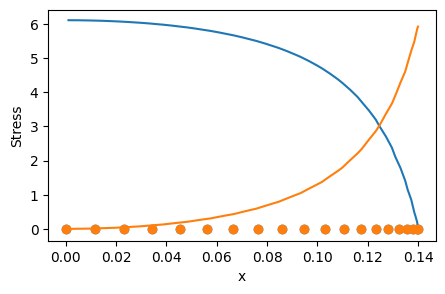

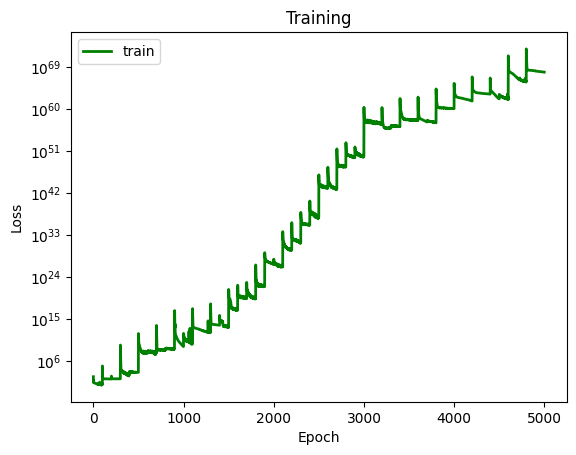

Weight_HNEU: 1.0, Weight_NEU: 1.0, Weight_PDE: 1.0, Weight_STRESS: 1.0, Stress Error: 30.427397928363156


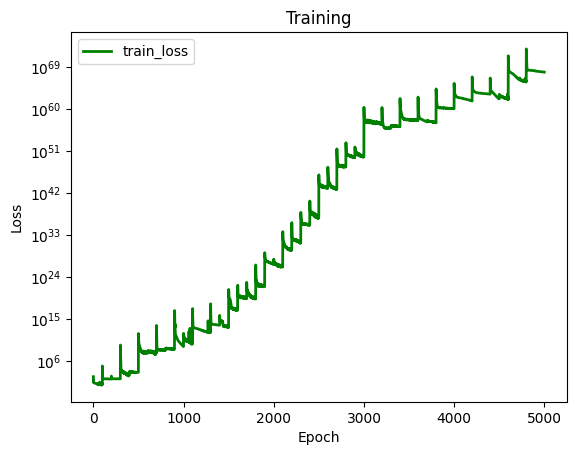

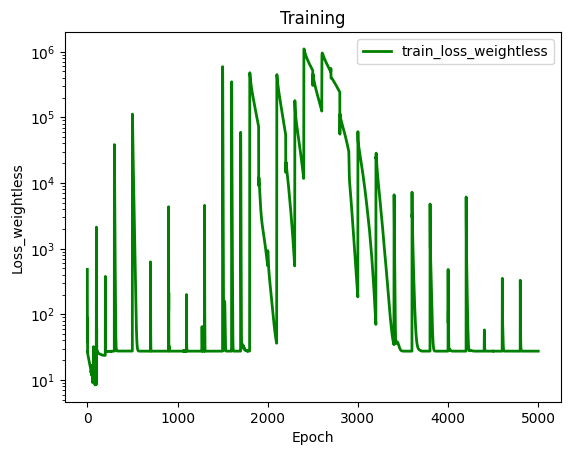

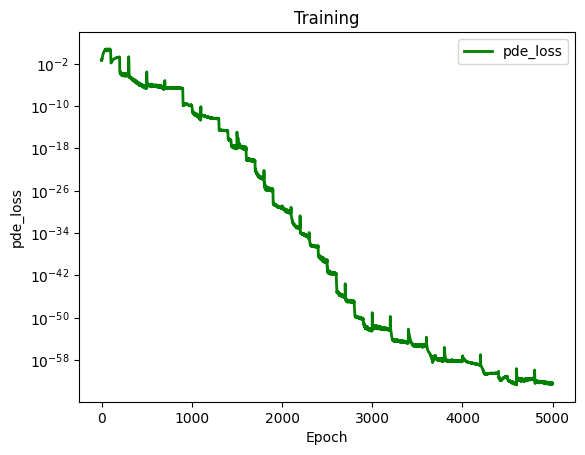

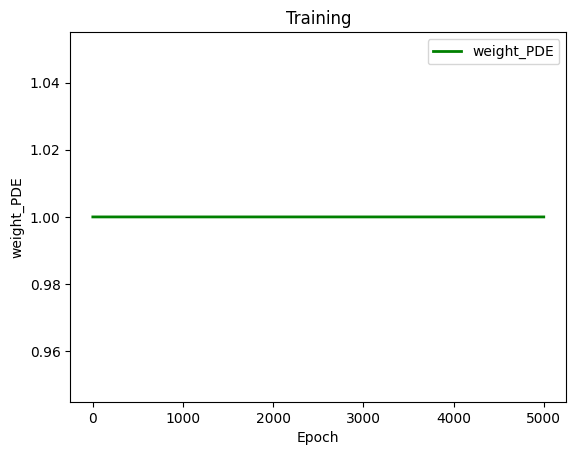

In [75]:

#scheduler = ExponentialLR(optimizer, gamma=0.999)
loss_history = []
pde_loss_history = []
loss_weightless_history = []
weight_history = []

# Weight of PDE lossWeight_NEU: 1.8841683879627231e-06, Weight_PDE: 3.1355081392423563e-06
# Weight of Neumann loss explicitly for the right and top boundary condition
W_NEU = 6.4531255763296895e-06 #previous value -> 1.88e-06
# Weight of Neumann loss explicitly for the hole boundary condition
W_HNEU = 8.2e-05
W_PDE = 8.376708219353885e-06 #previous value -> 3.14e-06
# Weight of data losses
W_DIR = 1.0
W_STRESS = 0.0 #previous value -> 1.0e-07 
W_DISP = 0.0


target_loss = torch.tensor(5e-06)

#Weight_NEU and Weight_PDE 
Weight_NEU = torch.tensor(W_NEU, requires_grad=True) #previous value -> 6.4531255763296895e-06
Weight_HNEU = torch.tensor(W_HNEU, requires_grad=True)
Weight_PDE = torch.tensor(W_PDE, requires_grad=True) #previous value -> 8.376708219353885e-06
Weight_DIR = torch.tensor(W_DIR, requires_grad=True)
Weight_STRESS = torch.tensor(W_STRESS, requires_grad=True)

#set all weights to 1 
Weight_NEU = torch.tensor(1.0, requires_grad=True) #previous value -> 6.4531255763296895e-06
Weight_HNEU = torch.tensor(1.0, requires_grad=True)
Weight_PDE = torch.tensor(1.0, requires_grad=True) #previous value -> 8.376708219353885e-06
Weight_DIR = torch.tensor(1.0, requires_grad=True)
Weight_STRESS = torch.tensor(1.0, requires_grad=True)


char_HNEU_loss= torch.tensor(0.029125697950096088)#torch.tensor(0.029125697950096088)
char_NEU_loss = torch.tensor(0.7272956427332002) #torch.tensor(0.7272956427332002)
char_pde_loss = torch.tensor(0.6245099393893354)
char_dirichlet_loss = torch.tensor(1.1044902637681307e-06)

# #constants for weight and Loss Non-dimensionalization
# slope = 1
# # Aggregate losses

# # Compute physics losses
# left_l, right_l, bottom_l, top_l, hole_l, pde_l = compute_physics_losses(collocation, top, right, left, bottom, hole)
# dirichlet_losses = left_l + bottom_l 
# neumann_losses = right_l + top_l 
# hole_neumann_losses = hole_l
# loss = (
#     dirichlet_losses
#     + Weight_NEU * neumann_losses
#     + Weight_HNEU * hole_neumann_losses
#     + Weight_PDE * pde_l
# )
# #selecting characteristic values:
# char_HNEU_loss= 0.029125697950096088, 
# char_NEU_loss = 0.7272956427332002
# char_pde_loss = 0.6245099393893354
# char_dirichlet_loss: 1.1044902637681307e-06

# #non dimensionalization of the loss function
# hole_neumann_losses_nd = hole_l / char_HNEU_loss
# neumann_losses_nd = (right_l + top_l) / char_NEU_loss
# pde_losses_nd = pde_l / char_pde_loss
# dirichlet_losses_nd = (left_l + bottom_l) / char_dirichlet_loss

# #compute total loss
# loss = (
#     Weight_HNEU * hole_neumann_losses_nd 
#     + Weight_NEU * neumann_losses_nd 
#     + Weight_PDE * pde_losses_nd 
#     + Weight_DIR * dirichlet_losses_nd 
# )





def training(compare_rad_x, target_loss):

    #reset all net parameters 
    #net.apply(weight_reset)

    #hyperparameter weights
    weights = [Weight_HNEU, Weight_NEU, Weight_PDE, Weight_DIR]
    
    
    p1 = Plate(compare_rad_x, N, M) 
    data_input, data_output, data_hole = p1.load_reference_data()
    compare_collo, compare_top, compare_right, compare_left, compare_bottom, compare_hole = p1.generate_dataset()

    #collocation, top, right, left, bottom, hole = generate_multiple_plates(0.04, 0.18, 0.01)
    collocation, top, right, left, bottom, hole = generate_multiple_plates(0.14, 0.14, 0.0)
    data_hole = data_hole.numpy()
    data_hole = data_hole[data_hole[:, 0].argsort()]
    data_stress_x = data_hole[:, 2]
    data_stress_y = data_hole[:, 3]

    #interpolate data_stress_x and data_stress_y
    f_stress_x = interp1d(data_hole[:, 0], data_hole[:, 2], kind='cubic')
    f_stress_y = interp1d(data_hole[:, 0], data_hole[:, 3], kind='cubic')
    x_new = np.linspace(data_hole[:, 0][-1], data_hole[:, 0][0], compare_hole[:, 0].size(dim=0))
    y_stress_x = f_stress_x(x_new)
    y_stress_y = f_stress_y(x_new)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    #scheduler = StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
    scheduler = ExponentialLR(optimizer,  gamma= 0.9995)
    print("Starting with Adam optimizer...")
    for epoch in tqdm(range(epochs)):
        # Permutation to shuffle collocation points randomly in each epoch
        permutation = torch.randperm(collocation.size()[0])

        for i in range(0, collocation.size()[0], batch_size):
            indices = permutation[i : i + batch_size]
            collo = collocation[indices]
            optimizer.zero_grad()

            # Compute physics losses
            left_l, right_l, bottom_l, top_l, hole_l, pde_l = compute_physics_losses(collo, top, right, left, bottom, hole)

            if W_DISP < 1E-10 and W_STRESS < 1E-10:
                # No data losses needed (we can accelerate training by skipping this part)
                stress_l = 0.0
                disp_l = 0.0
            else:
                # Get samples from reference solution
                samples = torch.randperm(data_output.size()[0])[::100]
                # Reference solutions
                s_data = data_output[samples, 0:3]
                e_data = data_output[samples, 4:7]
                u_data = data_output[samples, 7:10]
                # Predictions
                s_pred = torch.vmap(sigma)(data_input[samples, 0:3])
                e_pred = torch.vmap(epsilon)(data_input[samples, 0:3])
                u_pred = net(data_input[samples, 0:3])
                # Compute data losses
                ds_xx = mse(s_data[:, 0], s_pred[:, 0, 0])
                ds_yy = mse(s_data[:, 1], s_pred[:, 1, 1])
                ds_xy = mse(s_data[:, 2], s_pred[:, 0, 1])
                stress_l = ds_xx + ds_yy + ds_xy
                du_x = mse(u_data[:, 0], u_pred[:, 0])
                du_y = mse(u_data[:, 1], u_pred[:, 1])
                disp_l = du_x + du_y

            # Aggregate losses
            # dirichlet_losses = left_l + bottom_l 
            # neumann_losses = right_l + top_l 
            # hole_neumann_losses = hole_l
            # loss = (
            #     dirichlet_losses
            #     + Weight_NEU * neumann_losses
            #     + Weight_HNEU * hole_neumann_losses
            #     + Weight_PDE * pde_l
            #     + Weight_STRESS * stress_l
            #     #+ W_DISP * disp_l
            # )

            #non dimensionalization of the loss function
            hole_neumann_losses_nd = hole_l / char_HNEU_loss
            neumann_losses_nd = (right_l + top_l) / char_NEU_loss
            pde_losses_nd = pde_l / char_pde_loss
            dirichlet_losses_nd = (left_l + bottom_l) / char_dirichlet_loss

            loss = (
                    weights[0] * hole_neumann_losses_nd #Weight_HNEU 
                    + weights[1] * neumann_losses_nd  #Weight_NEU
                    + weights[2] * pde_losses_nd #Weight_PDE 
                    + weights[3] * dirichlet_losses_nd #Weight_DIR
                    )
            
            loss_weightless = (
                 hole_neumann_losses_nd 
                 + neumann_losses_nd 
                 + pde_losses_nd 
                 + dirichlet_losses_nd 
            )
            

            
            # Make optimization step after batch
            loss.backward(retain_graph=True)

            optimizer.step()

        # Make scheduler step after full epoch
        scheduler.step()

        #update non dimensionalizated weights 
        if (epoch+1) % 100 == 0:
            new_weights = [Weight_HNEU, Weight_NEU, Weight_PDE, Weight_DIR]
            with torch.no_grad():
                for index, weight in enumerate(weights):
                    # print(f"Gradient of weight: {index} w.r.t to L: {weight.grad}, old_weight: {weight}")
                    # print("weights_grad", weights[index].grad)
                    # print("zeros", torch.zeros(1))
                    # print("mse_of_weights_grad", mse(weights[index].grad, torch.zeros(1)))
                    # print("squared_error of weights_grad", weights[index].grad*weights[index].grad)
                    weight_grad_sum = (
                        (weights[0].grad * weights[0].grad) + (weights[1].grad * weights[1].grad)
                    + (weights[2].grad * weights[2].grad) + (weights[3].grad * weights[3].grad)
                    )
                    new_weights[index] = weight_grad_sum/ (weight.grad * weight.grad)

                #update new weights
                for index, weight in enumerate(weights):
                    weights[index] = torch.tensor(0.9*weight + 0.1*new_weights[index], requires_grad=True)
                    print(f"for weight {index} new weight_value: {weights[index]}")
                    
                    
        
        # append loss to history (=for plotting)
        with torch.autograd.no_grad():
            loss_history.append(float(loss.data))
            loss_weightless_history.append(float(loss_weightless.data))
            pde_loss_history.append(float(pde_losses_nd))
            weight_history.append(float(Weight_PDE))

        
        if (epoch+1) % 100 == 0:
            print(f"total_loss: {loss_weightless.data}, hole_loss:  {hole_neumann_losses_nd}, neumann_loss:  {neumann_losses_nd}, pde_loss: {pde_losses_nd}, dirichlet_loss: {dirichlet_losses_nd}")


    print(f"total_loss: {loss_weightless.data}, hole_loss:  {hole_neumann_losses_nd}, neumann_loss:  {neumann_losses_nd}, pde_loss: {pde_losses_nd}, dirichlet_loss: {dirichlet_losses_nd}")

    # compare computed stressError(PINN) with actual stressError
    stress_hole = torch.vmap(sigma)(compare_hole[:, :-2])
    stressError = mse(stress_hole[:, 0, 0], torch.tensor(y_stress_x)) + mse(stress_hole[:, 1, 1], torch.tensor(y_stress_y))

    lowest_loss = target_loss
    if(loss.data < target_loss):
        print(f"previous lowest lost  {target_loss}")
        lowest_loss = loss.data
        print(f"lowest loss {lowest_loss} archived, PINN is saved: 'net_param/net_{lowest_loss:.8f}.pth")
        torch.save(net.state_dict(), f'net_param/net_{lowest_loss:.8f}.pth')
    return stressError, data_hole, stress_hole, compare_hole, lowest_loss


# weights_optimizer = torch.optim.Adam([Weight_NEU, Weight_PDE], lr=1)
# weights_scheduler = ExponentialLR(weights_optimizer, gamma=1)
for i in range(1):
#weights_optimizer.zero_grad()
    net = Net()
    mse_error, data_hole, stress_hole, hole, lowest_loss = training(0.14, target_loss)
    target_loss = lowest_loss

    #mse_error.backward()
    #weights_optimizer.step()
    #weights_scheduler.step()

    #save net parameters
    #torch.save(net.state_dict(), f'net_param/net_{rad_x:.2f}.pth')


    with torch.autograd.no_grad():
        #weight_history.append(float(mse_error.data))
        plt.figure(figsize=(5, 3))
        plt.plot(hole[:, 0], stress_hole[:, 0, 0], "o", color="tab:blue", label="σ_xx (PINN)")
        plt.plot(data_hole[:, 0], data_hole[:, 2], "-", color="tab:blue", label="σ_xx (FEM)")
        plt.plot(hole[:, 0], stress_hole[:, 1, 1], "o", color="tab:orange", label="σ_yy (PINN)")
        plt.plot(data_hole[:, 0], data_hole[:, 3], "-", color="tab:orange", label="σ_yy (FEM)")
        plt.xlabel("x")
        plt.ylabel("Stress")
        #plt.legend()
        plt.show()

        plt.plot(loss_history, c='g', label='train', linewidth=2.0)
        plt.yscale("log")
        plt.title("Training")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()
    
    # print weights and stress error and modify weight values for the next iteration
    print(f"Weight_HNEU: {Weight_HNEU.item()}, Weight_NEU: {Weight_NEU.item()}, Weight_PDE: {Weight_PDE.item()}, Weight_STRESS: {Weight_STRESS.item()}, Stress Error: {mse_error.item()}") 
    #Weight_STRESS = Weight_STRESS *1/1.1
    # Weight_NEU = Weight_NEU * (1.1/1.0)
    # Weight_PDE = Weight_PDE * (1.1/1.0)
    # Weight_HNEU = Weight_HNEU * (1.1/1.0)

#plt.figure(figsize=(8, 4))
plt.plot(loss_history, c='g', label='train_loss', linewidth=2.0)
plt.yscale("log")
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(loss_weightless_history, c='g', label='train_loss_weightless', linewidth=2.0)
plt.yscale("log")
plt.title("Training")
plt.ylabel("Loss_weightless")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(pde_loss_history, c='g', label='pde_loss', linewidth=2.0)
plt.yscale("log")
plt.title("Training")
plt.ylabel("pde_loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(weight_history, c='g', label='weight_PDE', linewidth=2.0)
plt.title("Training")
plt.ylabel("weight_PDE")
plt.xlabel("Epoch")
plt.legend()
plt.show()




## Visualization of results

In [76]:
val_rad_x = 0.14
val_plate = Plate(val_rad_x, N, M) 
data_input, data_output, data_hole = val_plate.load_reference_data()
val_collo, val_top, val_right, val_left, val_bottom, val_hole = val_plate.generate_dataset()

stress_hole = torch.vmap(sigma)(val_hole[:,:-2])
data_hole = np.loadtxt(f"data/hole_Rx={Rx}.csv", delimiter=",")
data_hole = data_hole[data_hole[:, 0].argsort()]

with torch.no_grad():
    fig = go.Figure()
    m1 = dict(color="blue")
    m2 = dict(color="orange")
    fig.add_trace(
        go.Scatter(
            x=hole[:, 0],
            y=stress_hole[:, 0, 0],
            marker=m1,
            mode="markers",
            name="σ_xx (PINN)",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=data_hole[:, 0],
            y=data_hole[:, 2],
            marker=m1,
            mode="lines",
            name="σ_xx (FEM)",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=hole[:, 0],
            y=stress_hole[:, 1, 1],
            marker=m2,
            mode="markers",
            name="σ_yy (PINN)",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=data_hole[:, 0],
            y=data_hole[:, 3],
            marker=m2,
            mode="lines",
            name="σ_yy (FEM)",
        )
    )
    fig.update_layout(
        template="none", width=600, height=400, title="Stress at hole", showlegend=True
    )
    fig.show()

In [77]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_r = Rx * np.ones(np.shape(val_x))
val_domain = np.vstack([val_x.ravel(), val_y.ravel(), val_r.ravel()]).T
mask = (
    ((val_domain[:, 0] ** 2) / (Rx**2)) + ((val_domain[:, 1] ** 2) / (Ry**2))
) > 1
val = torch.tensor(val_domain[mask], requires_grad=True).double()


# Compute model predictions on the validation domain
disp = net(val)
def_val = val[:, :-1] + disp
stress = torch.vmap(sigma)(val)
mises = torch.sqrt(
    stress[:, 0, 0] ** 2
    + stress[:, 1, 1] ** 2
    - stress[:, 0, 0] * stress[:, 1, 1]
    + 3 * stress[:, 0, 1] ** 2
)
# print([loss.item() for loss in compute_les(val)])


@torch.no_grad()
def make_plot(x, y, variable, title, cmap=sequential.Viridis, size=8.0):
    fig = go.Figure()

    # Plot boundaries
    m = dict(color="black")
    fig.add_trace(go.Scatter(x=top[:, 0], y=top[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=bottom[:, 0], y=bottom[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=left[:, 0], y=left[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=right[:, 0], y=right[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=hole[:, 0], y=hole[:, 1], mode="lines", marker=m))

    # Plot variable values
    m = dict(color=variable, colorscale=cmap, size=size, colorbar=dict(thickness=10))
    fig.add_trace(go.Scatter(x=x, y=y, marker=m, mode="markers"))

    # plot settings
    fig.layout.yaxis.scaleanchor = "x"
    fig.update_layout(
        template="none", width=400, height=400, title=title, showlegend=False
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()


# Compute data error
s_data = data_output[:, 0:3]
s_pred = torch.vmap(sigma)(data_input[:, 0:3])
ds_xx = s_data[:, 0] - s_pred[:, 0, 0]
ds_yy = s_data[:, 1] - s_pred[:, 1, 1]
ds_xy = s_data[:, 2] - s_pred[:, 0, 1]


# Plot stress errors
cmap = sequential.RdBu_r
make_plot(*data_input[:, 0:2].T, ds_xx, "Stress error xx", size=2.0, cmap=cmap)
make_plot(*data_input[:, 0:2].T, ds_yy, "Stress error yy", size=2.0, cmap=cmap)
make_plot(*data_input[:, 0:2].T, ds_xy, "Stress error xy", size=2.0, cmap=cmap)

# Plot stresses
make_plot(*def_val.T, stress[:, 0, 0], "Stress xx")
make_plot(*def_val.T, stress[:, 0, 1], "Stress xy")
make_plot(*def_val.T, stress[:, 1, 1], "Stress yy")
make_plot(*def_val.T, mises, "Mises stress")

# Plot displacements
make_plot(*def_val.T, disp[:, 0], "Displacement in x", cmap=sequential.Inferno)
make_plot(*def_val.T, disp[:, 1], "Displacement in y", cmap=sequential.Inferno)
